# Projeto de Object Detection com YOLOv5

## Como Começar
Este notebook tem como objetivo treinar um modelo de detecção de objetos utilizando a arquitetura YOLOv5. Vamos utilizar um dataset contendo imagens de tubarões, raias e peixes para treinar nosso modelo.

## Objetivos
O principal objetivo deste projeto é desenvolver um modelo capaz de identificar e localizar tubarões, raias e peixes em imagens, contribuindo para pesquisas em biologia marinha, conservação e monitoramento maritimo.

## Dependências
Para executar este notebook, é necessário ter as seguintes dependências instaladas:
- PyTorch
- torchvision
- OpenCV
- YOLOv5
- Yaml
- Utils
- Outras bibliotecas de suporte (Glob, os, random)

## Quem Fez
Este notebook foi desenvolvido por Henrique Baptista.


[GitHub](https://github.com/henriquebap)
## Atribuição de Créditos
Agradecimentos especiais à Ultralytics e Roboflow por fornecerem ferramentas e recursos essenciais para este projeto.

---

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

Let's get started!

# Instalar Dependencias

_(Lembre de escolher GPU no Runtime se não estiver selecionado. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [ ]:
# Clonar YOLOv5 repositorio
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5
HEAD is now at 064365d8 Update parse_opt() in export.py to work as in train.py (#10789)


In [ ]:
!pip install -qr requirements.txt  # install dependencies (ignore errors)
!pip install roboflow


In [ ]:
# instalar dependencias necessarias
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.2.1+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


##  Download o Dataset

Adicione a API key do Roboflow para baixar o dataset.
Como alternativa, use o codidgo dado pelo Roboflow dashboard.

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("cp3-detection").project("checkpoint-visao-computacional")
version = project.version(1)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
%cd /content/yolov5

/content/yolov5


In [ ]:
# Este é o arquivo YAML que a Roboflow escreveu para nós e que estamos carregando neste notebook com nossos dados.
%cat {dataset.location}/data.yaml

names:
- '0'
- '1'
- '2'
nc: 3
roboflow:
  license: CC BY 4.0
  project: checkpoint-visao-computacional
  url: https://universe.roboflow.com/cp3-detection/checkpoint-visao-computacional/dataset/1
  version: 1
  workspace: cp3-detection
test: ../test/images
train: CheckPoint---Visao-Computacional-1/train/images
val: CheckPoint---Visao-Computacional-1/valid/images


# Define Configuração e Arquitetura do Modelo

Vamos escrever um script YAML que define os parâmetros para o nosso modelo, como o número de classes, âncoras e cada camada.

In [ ]:
# define numero de classes baseado no YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#esse e a configuração de modelo que vamos usar
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#iPython writefile para que possamos escrever variáveis
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parametros
nc: {num_classes}  # numero de classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train YOLOv5 Detector


Aqui, podemos passar vários argumentos:

- **img**: define o tamanho da imagem de entrada
- **batch**: determina o tamanho do lote
- **epochs**: define o número de épocas de treinamento. (Nota: frequentemente, mais de 3000 são comuns aqui!)
- **data**: define o caminho para nosso arquivo yaml
- **cfg**: especifica a configuração do nosso modelo
- **weights**: especifica um caminho personalizado para os pesos. (Nota: você pode baixar os pesos da pasta do Ultralytics Google Drive) [aqui](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J)
- **name**: nomes dos resultados
- **nosave**: salvar apenas o checkpoint final
- **cache**: cache de imagens para treinamento mais rápido

In [ ]:
# train yolov5s data 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
2024-05-07 20:38:53.512806: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 20:38:53.512861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 20:38:53.517475: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-07 20:38:57.246884: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/yolov5/CheckPoint---Visao-Computacional-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=

# Avaliar o Desempenho do Detector YOLOv5 Personalizado


As perdas de treinamento e as métricas de desempenho também são salvas no Tensorboard e também em um arquivo de log definido acima com a flag --name quando treinamos. No nosso caso, nomeamos isso como yolov5s_results.

Nota do Glenn: Arquivos results.txt parcialmente completados podem ser plotados com from utils.utils import plot_results; plot_results().

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

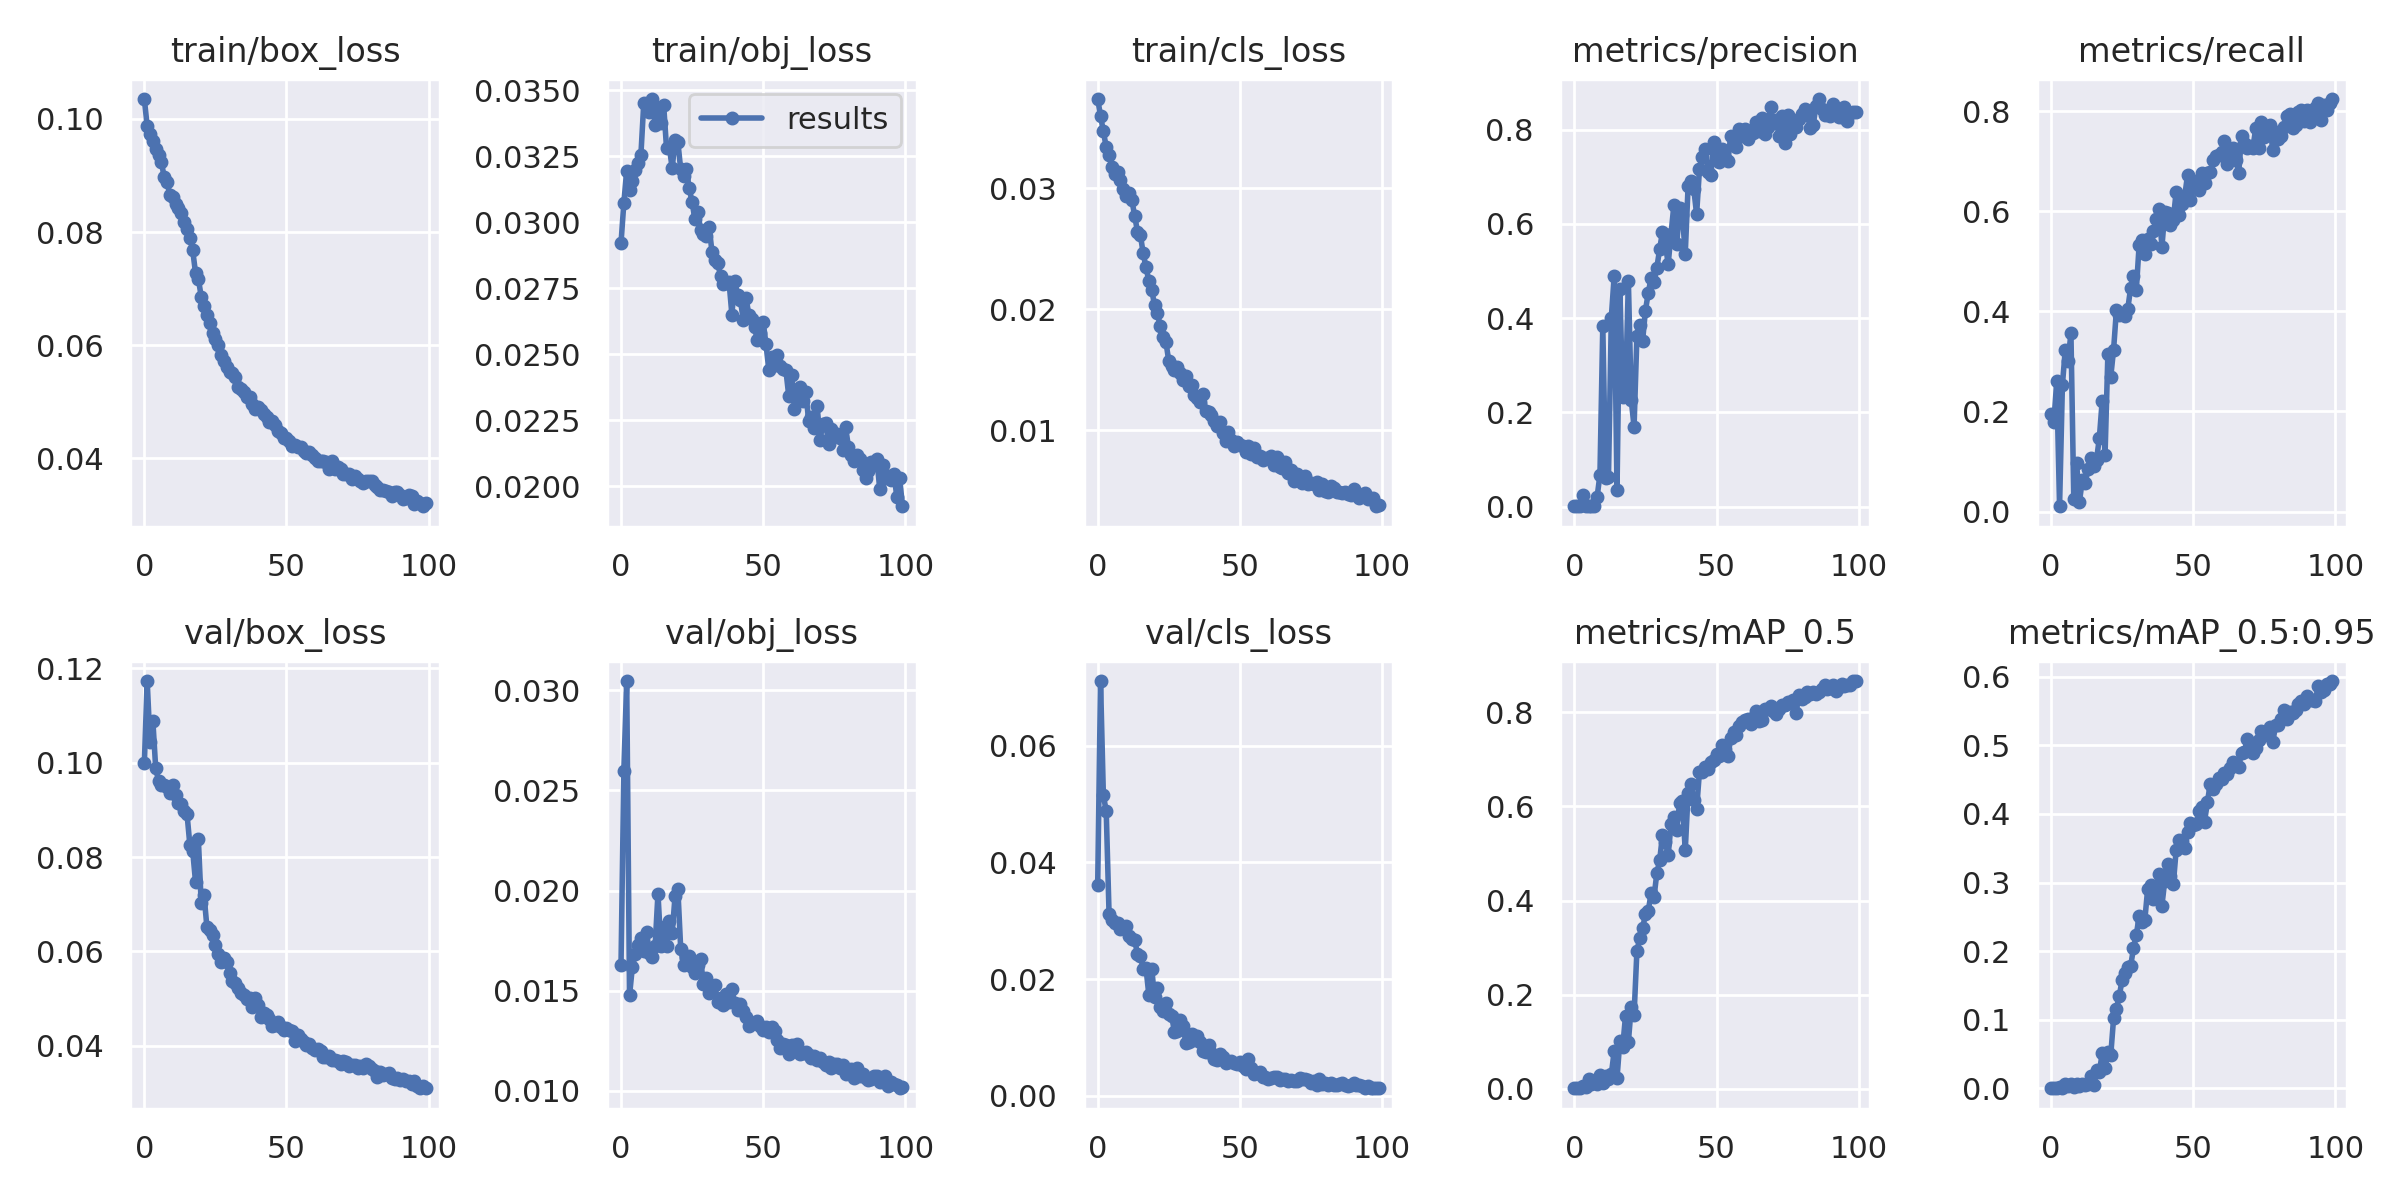

In [ ]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results2/results.png', width=1000)  # view results.png

### Training Data with Labels

Após o início do treinamento, visualize as imagens train*.jpg para ver as imagens de treinamento, os rótulos e os efeitos de aumento.

Observe que um carregador de dados em mosaico é usado para treinamento (mostrado abaixo), um novo conceito de carregamento de dados desenvolvido por Glenn Jocher e apresentado pela primeira vez no[YOLOv4](https://arxiv.org/abs/2004.10934).

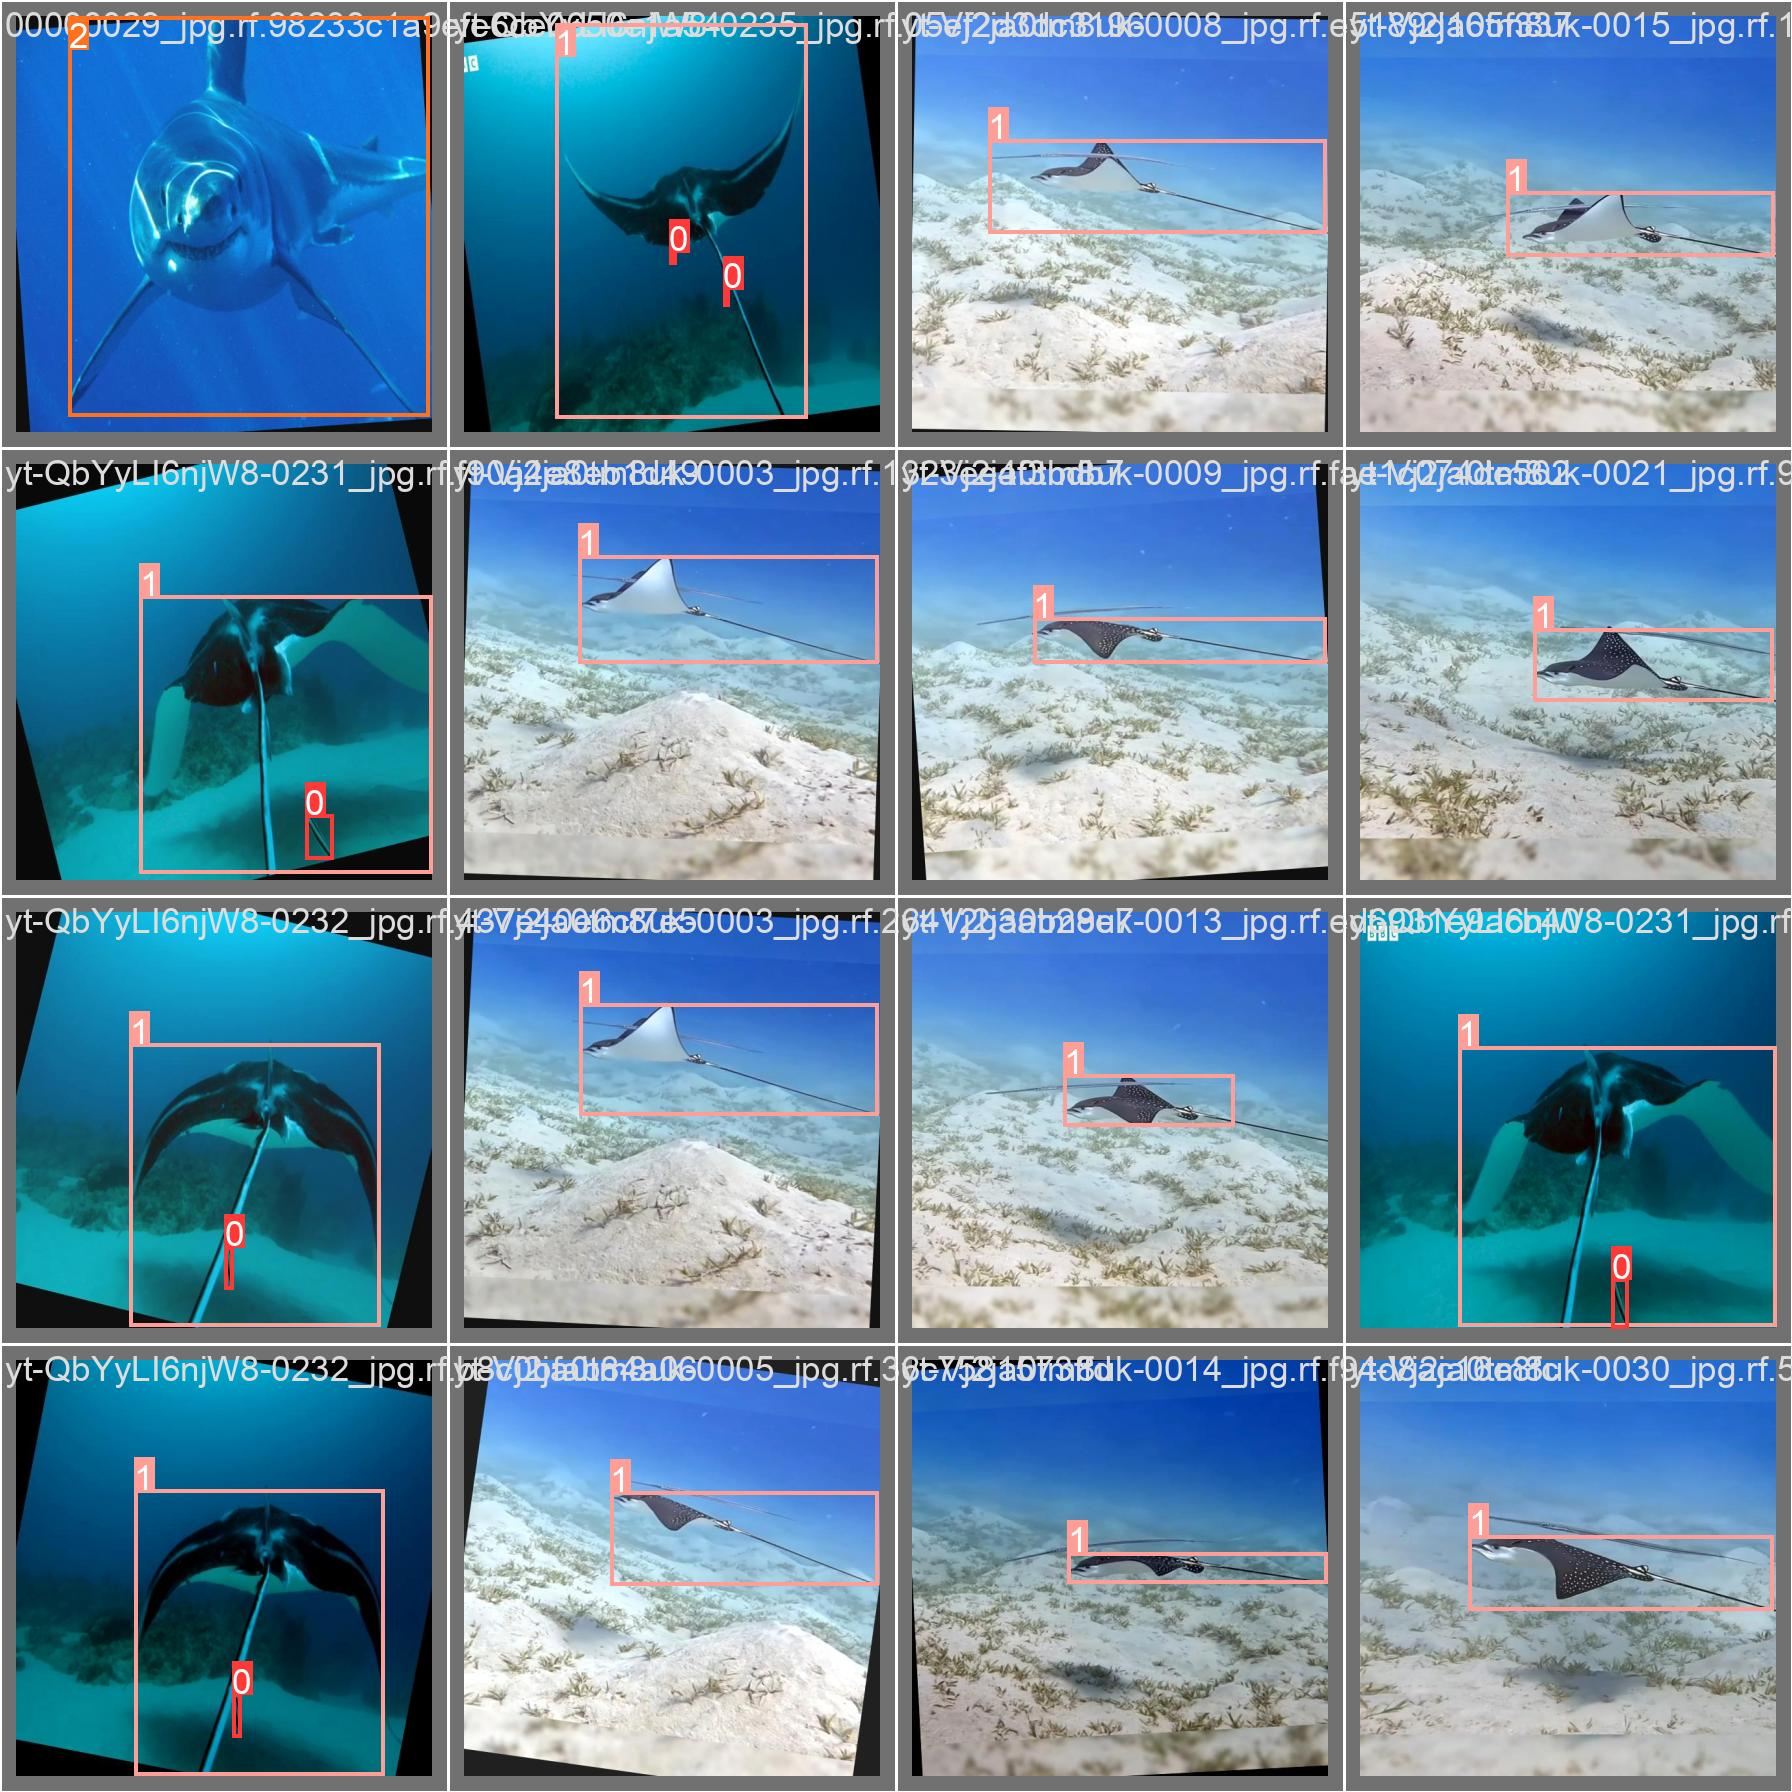

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results2/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


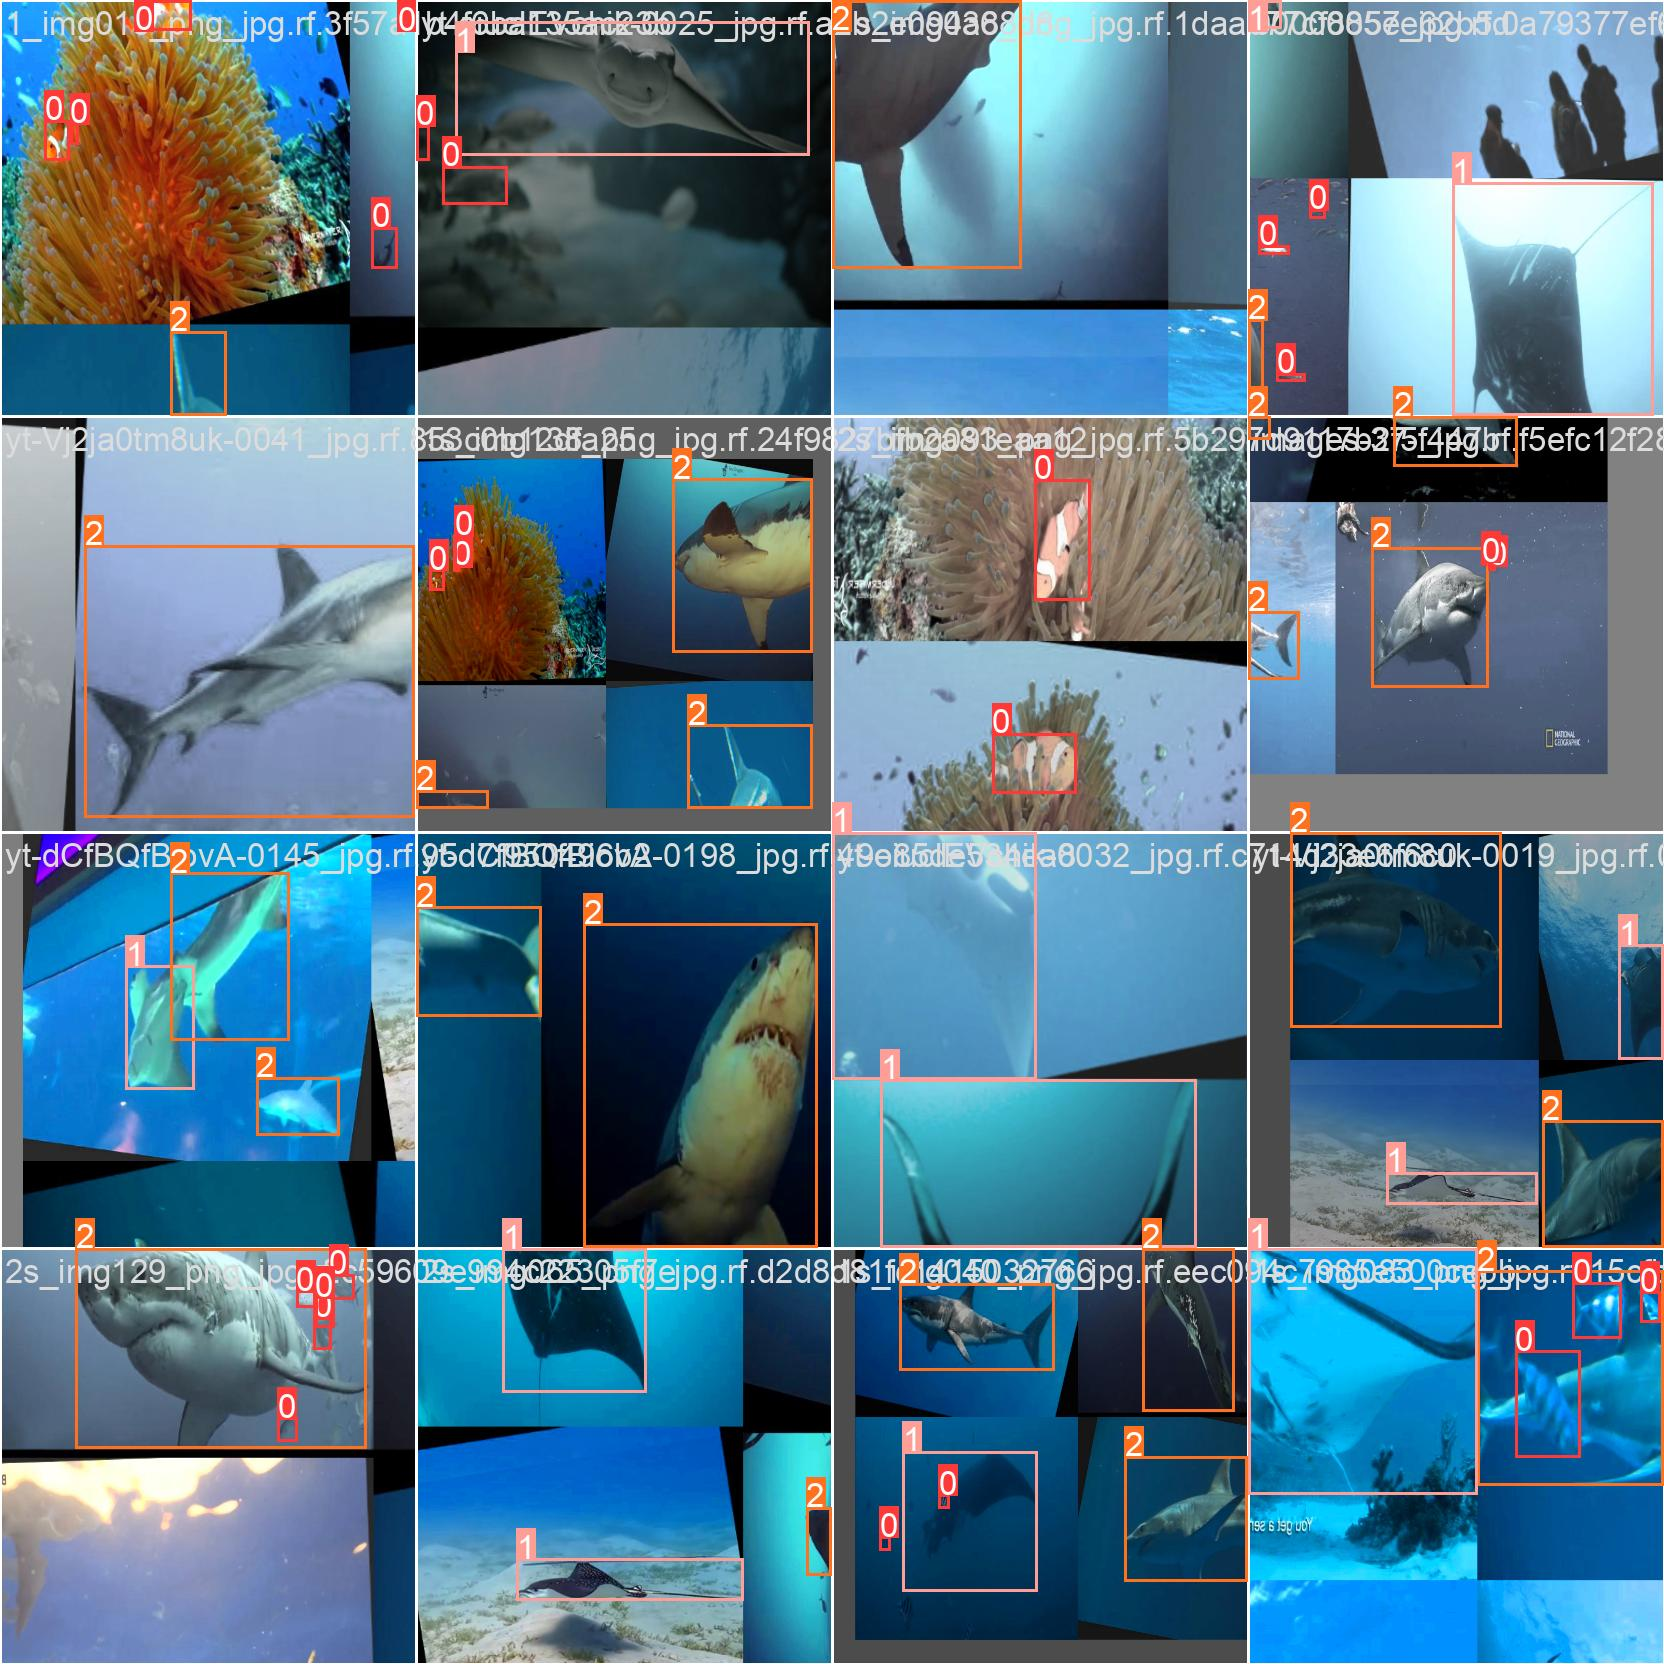

In [ ]:
# Imprimir um exemplo de treinamento aumentado
print("DADOS DE TREINAMENTO AUMENTADOS COM A VERDADE NO TERRENO:")
Image(filename='/content/yolov5/runs/train/yolov5s_results2/train_batch0.jpg', width=900)

# Executar Inferência Com Pesos Treinados


A seguir, podemos executar a inferência com um checkpoint pré-treinado em todas as imagens na pasta `test/images` para entender como nosso modelo se comporta no nosso conjunto de testes.

In [ ]:
# Os pesos treinados são salvos por padrão na nossa pasta de pesos
%ls runs/

train/


In [ ]:
%ls runs/train/yolov5s_results2/weights

best.pt  last.pt


`checkpoint-visao-computacional`

In [ ]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results2/weights/best.pt --img 416 --conf 0.4 --source checkpoint-visao-computacional-10/test/images/

/content/yolov5
detect: weights=['runs/train/yolov5s_results2/weights/best.pt'], source=Cash-Counter-10/test/images/, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d8 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7251912 parameters, 0 gradients
Traceback (most recent call last):
  File "/content/yolov5/detect.py", line 261, in <module>
    main(opt)
  File "/content/yolov5/detect.py", line 256, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, *

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp3/*.jpg')[:10]: #assuming JPG
    display(Image(filename=imageName))

## Implantando o Modelo no Roboflow

upload dos pesos do seu modelo para o Roboflow Deploy para usar seus pesos treinados no Roboflow.

A função .deploy() no pacote pip do[Roboflow pip package](https://docs.roboflow.com/python) agora suporta o upload de pesos do YOLOv5

**Antes de executar este código, verifique a versao do projeto e a versao no painel do Roboflow**

In [ ]:
rf = Roboflow(api_key="")
project = rf.workspace("cp3-detection").project("checkpoint-visao-computacional")
dataset = project.version(2)

project.version(dataset.version).deploy(model_type="yolov5", model_path=f"/content/yolov5/runs/train/yolov5s_results2/")

loading Roboflow workspace...
loading Roboflow project...
View the status of your deployment at: https://app.roboflow.com/cp3-detection/checkpoint-visao-computacional/2
Share your model with the world at: https://universe.roboflow.com/cp3-detection/checkpoint-visao-computacional/model/2


In [ ]:
#Run inference on your model on a persistant, auto-scaling, cloud API

#load model
model = project.version(dataset.version).model

#choose random test set image
import os, random
test_set_loc = dataset.location + "/test/images/"
random_test_image = random.choice(os.listdir(test_set_loc))
print("running inference on " + random_test_image)

pred = model.predict(test_set_loc + random_test_image, confidence=40, overlap=30).json()
pred

AttributeError: 'Version' object has no attribute 'location'

# Model Deploy at cloud

Além de usar a API hospedada da Roboflow para implantação, você pode usar [Roboflow Inference](https://inference.roboflow.com), uma solução de inferência de código aberto que alimentou milhões de chamadas de API em ambientes de produção. A inferência funciona com CPU e GPU, dando a você acesso imediato a uma variedade de dispositivos, desde o NVIDIA Jetson até dispositivos compatíveis com TRT até dispositivos ARM CPU.

Com o Roboflow Inference, você pode hospedar e implantar seu modelo no dispositivo. Você pode implantar aplicativos usando os [Inference Docker containers](https://inference.roboflow.com/quickstart/docker/) oou o pacote pip

Por exemplo, para instalar a Inferência em um dispositivo com uma GPU NVIDIA, podemos usar:

**Nota: Este método não foi testado e é apenas uma ideia para implementação e utilização.**


```
docker pull roboflow/roboflow-inference-server-gpu
```

via HTTP:

```python
import requests

workspace_id = ""
model_id = ""
image_url = ""
confidence = 0.75
api_key = ""
iou_threshold = 0.5

infer_payload = {
    "image": {
        "type": "url",
        "value": image_url,
    },
    "confidence": confidence,
    "iou_threshold": iou_threshold,
    "api_key": api_key,
}
res = requests.post(
    f"http://localhost:9001/{workspace_id}/{model_id}",
    json=infer_object_detection_payload,
)

predictions = res.json()
```

 Roboflow workspace ID, model ID, and API key.

- [Encontre o workspace and model ID](https://docs.roboflow.com/api-reference/workspace-and-project-ids?ref=blog.roboflow.com)
- [Encontre API key](https://docs.roboflow.com/api-reference/authentication?ref=blog.roboflow.com#retrieve-an-api-key)

Além disso, defina a URL de uma imagem na qual você deseja executar a inferência. Isso pode ser um arquivo local.

Para usar seu modelo YOLOv5 comercialmente com Inference, você precisará de uma licença Roboflow Enterprise, por meio da qual você obtém uma licença de passagem para usar o YOLOv5. Uma licença empresarial também concede acesso a recursos como gerenciamento avançado de dispositivos, contêineres multi-modelo, inferência automática em lote e muito mais._